# Exercise 1: Basic image processing

## (a) Read the image from the file umbrellas.jpg and display it using the following snippet:

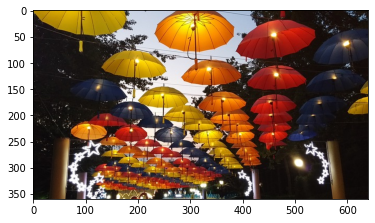

In [2]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

I = cv2.imread("images/umbrellas.jpg")
I = cv2.cvtColor(I, cv2.COLOR_BGR2RGB) # from BGR to RGB
plt.imshow(I)
plt.show()

notes:

In [3]:
height, width, channels = I.shape
print(height, width, channels)

I_float = I.astype(np.float) # from uint8 to float

I_new = np.copy(I) # copy of I

360 640 3


## (b) Convert the loaded image to grayscale. 

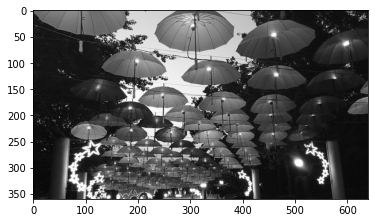

In [4]:
#I_RGB = cv2.cvtColor(I, cv2.COLOR_BGR2RGB)
I_float = I.astype(np.float)

red, green, blue = I_float[:,:,0], I_float[:,:,1], I_float[:,:,2]
I_float_gray = (red + green + blue) / 3
plt.imshow(I_float_gray, cmap='gray')
plt.show()

## (c) Cut and display a specific part of the loaded image. 

*Question: Why would you use different color maps?*

To visualize different data, eg. heatmap for IR camera etc.

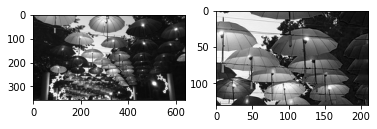

In [5]:
cutout = I[130:260, 240:450, 1]

plt.subplot(1,2,1)
plt.imshow(I[:,:,1], cmap='gray')
plt.subplot(1,2,2)
plt.imshow(cutout, cmap='gray')
plt.show()

## (d) You can also replace only a part of the image using indexing. 

*Question: How is inverting a grayscale value defined for uint8 ?*

255 - original

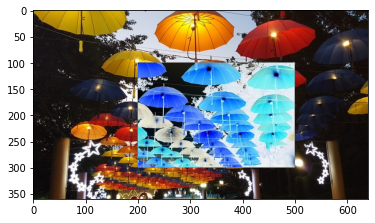

In [6]:
I_d = I.copy()
I_d[100:300, 200:500, :] = 255-I_d[100:300, 200:500, :]

plt.imshow(I_d)
plt.show()

## (e) Perform a reduction of grayscale levels in the image.

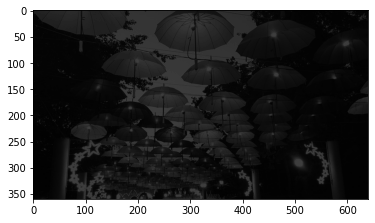

In [7]:
I = cv2.imread("images/umbrellas.jpg")
I = cv2.cvtColor(I, cv2.COLOR_BGR2GRAY)
I = I.astype(np.float)
I = 63*I/255
I = I.astype(np.uint8)

plt.imshow(I, cmap='gray', vmax=255)
plt.show()

---
# Exercise 2: Thresholding and histograms

## (a) Create a binary mask from a grayscale image. 

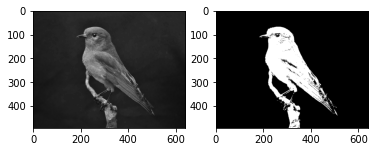

In [8]:
I = cv2.imread("images/bird.jpg")
I = cv2.cvtColor(I, cv2.COLOR_BGR2GRAY)


threshold = 55
I_mask = np.zeros_like(I)
I_mask[I<threshold] = 0
I_mask[I>=threshold] = 1

plt.subplot(121)
plt.imshow(I, cmap='gray')
plt.subplot(122)
plt.imshow(I_mask, cmap='gray')
plt.show()

## (b) Histogram

*Question: The histograms are usually normalized by dividing the result by the
sum of all cells. Why is that?*

So that the results don't depend on the number of pixels (resolution) of the image. The normalized histogram then also represents the probability of a random pixels falling into a specific bin

In [9]:
def myhist(I, n_bins):
	H = np.zeros(n_bins)
	pixels = I.reshape(-1)
	bin_size = 256/n_bins
	for i in range(n_bins):
		H[i] = np.sum((pixels >= (i * bin_size)) * (pixels < ((i+1) * bin_size)))
	'''for p in pixels:
		H[int(p//bin_size)] += 1'''
	return H / pixels.shape
	

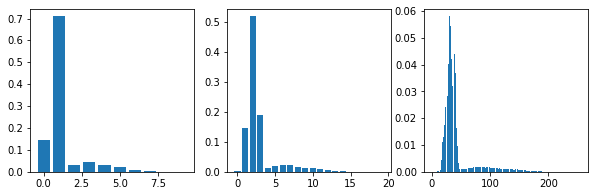

In [11]:
I = cv2.imread("images/bird.jpg")
I = cv2.cvtColor(I, cv2.COLOR_BGR2GRAY)

h1 = myhist(I, 10)
h2 = myhist(I, 20)
h3 = myhist(I, 256)

plt.rcParams["figure.figsize"] = (10,3)
plt.subplot(131)
plt.bar(np.arange(10), h1)
plt.subplot(132)
plt.bar(np.arange(20), h2)
plt.subplot(133)
plt.bar(np.arange(256), h3)
plt.show()

## (c) F (5 points) Modify your function myhist to no longer assume the uint8 range for values. 

In [12]:
def myhist2(I, n_bins):
	H = np.zeros(n_bins)
	pixels = I.reshape(-1)

	start = pixels.min()
	end = pixels.max()
	bin_size = (end - start + 1)/n_bins

	for i in range(n_bins):
		H[i] = np.sum((pixels >= (start + i * bin_size)) * (pixels < (start + (i+1) * bin_size)))
	return H / pixels.shape

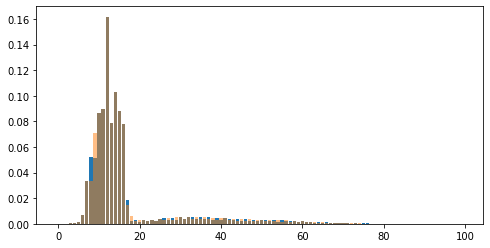

In [13]:
I = cv2.imread("images/bird.jpg")
I = cv2.cvtColor(I, cv2.COLOR_BGR2GRAY)

h1 = myhist(I, 100)
h2 = myhist2(I, 100)

plt.rcParams["figure.figsize"] = (8,4)
plt.bar(np.arange(100), h1)
plt.bar(np.arange(100), h2, alpha=0.5)
plt.show()

## (d) F (5 points) Test myhist function on images (three or more) of the same scene in different lighting conditions. 

The darker the image, the more to the left is the histogram balanced. But using a webcam it automatically exposes image for the lightning conditions so it is not as apparent as using manual exposure on  a camera

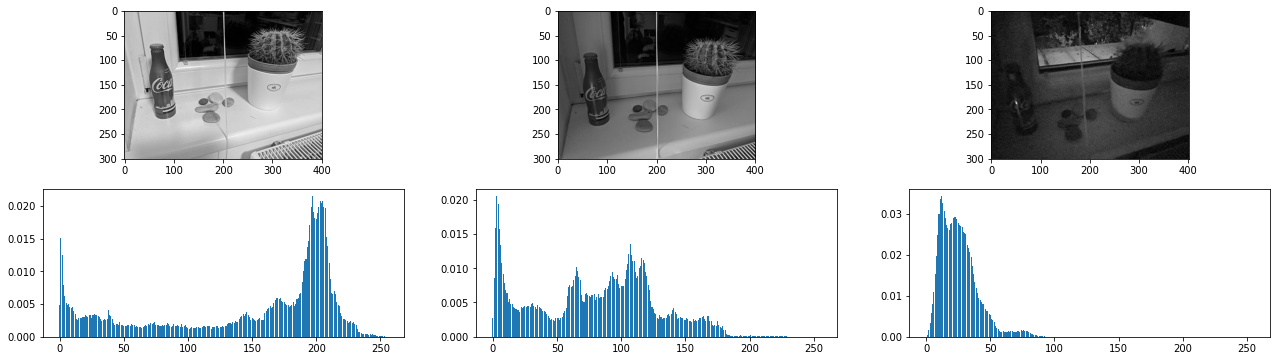

In [43]:
I1 = cv2.imread("images/P1.jpg")
I1 = cv2.cvtColor(I1, cv2.COLOR_BGR2GRAY)

I2 = cv2.imread("images/P2.jpg")
I2 = cv2.cvtColor(I2, cv2.COLOR_BGR2GRAY)

I3 = cv2.imread("images/P3.jpg")
I3 = cv2.cvtColor(I3, cv2.COLOR_BGR2GRAY)

h1 = myhist(I1, 256)
h2 = myhist(I2, 256)
h3 = myhist(I3, 256)

plt.rcParams["figure.figsize"] = (22,6)
plt.subplot(231)
plt.imshow(I1, cmap="gray")
plt.subplot(232)
plt.imshow(I2, cmap="gray")
plt.subplot(233)
plt.imshow(I3, cmap="gray")

plt.subplot(234)
plt.bar(np.arange(256), h1)
plt.subplot(235)
plt.bar(np.arange(256), h2)
plt.subplot(236)
plt.bar(np.arange(256), h3)
plt.show()

## (e) F (15 points) Implement **Otsu’s method** for automatic threshold calculation. 

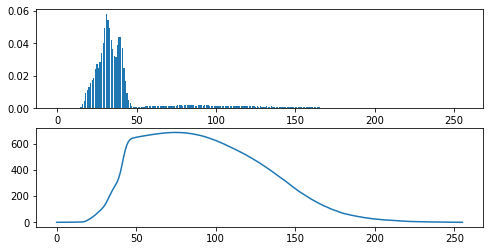

75


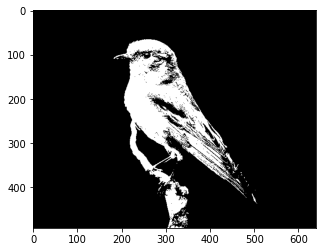

In [19]:
I = cv2.imread("images/bird.jpg")
I = cv2.cvtColor(I, cv2.COLOR_BGR2GRAY)

H = myhist(I, 256)
plt.subplot(211)
plt.bar(np.arange(256), H)

# zacetne vrednosti
n1 = 0
n2 = H.sum()
m1 = 0
m2 = 0
for i in range(256):
	m2 += i*H[i]
m2 /= n2

ss = np.zeros_like(H)
s = n1*n2*(m1-m2)**2
ss[0] = s
for i in range(255):
	m1 = m1*n1 + i*H[i]
	m2 = m2*n2 - i*H[i]
	n1 += H[i]
	n2 -= H[i]
	m1 /= n1
	m2 /= n2
	s = n1*n2*(m1-m2)**2
	ss[i+1] = s

plt.subplot(212)
plt.plot(ss)
plt.show()

thr = ss.argmax()
print(thr)

I_mask = np.zeros_like(I)
I_mask[I<thr] = 0
I_mask[I>=thr] = 1
plt.imshow(I_mask, cmap='gray')
plt.show()

# Exercise 3: Morphological operations and region

In [20]:
I = cv2.imread("images/mask.png")
I = cv2.cvtColor(I, cv2.COLOR_BGR2GRAY)

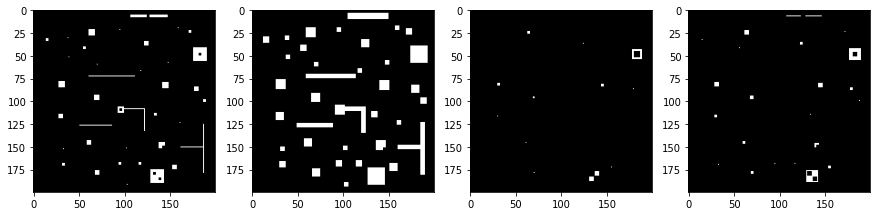

In [21]:
plt.rcParams["figure.figsize"] = (15,6)
plt.subplot(141)
plt.imshow(I, cmap="gray")

n = 5
SE = np.ones((n,n), np.uint8)
I_eroded = cv2.erode(I, SE)
I_dilated = cv2.dilate(I, SE) # closing

plt.subplot(142)
plt.imshow(I_dilated, cmap="gray")

I_dilated2 = cv2.dilate(I, SE)
I_eroded2 = cv2.erode(I, SE)

plt.subplot(143)
plt.imshow(I_eroded2, cmap="gray")

n = 3
SE = np.ones((n,n), np.uint8)
I_dilated3 = cv2.dilate(I, SE)
I_eroded3 = cv2.erode(I, SE)

plt.subplot(144)
plt.imshow(I_eroded3, cmap="gray")

plt.show()

## Try to clean up the mask of the image bird.jpg

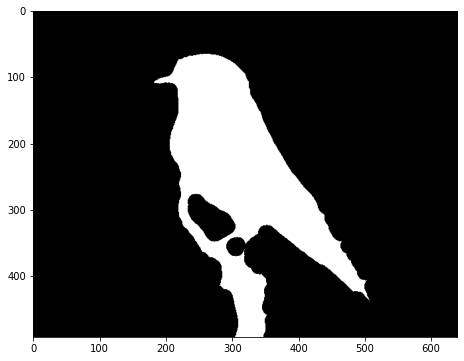

In [22]:
I = cv2.imread("images/bird.jpg")
I = cv2.cvtColor(I, cv2.COLOR_BGR2GRAY)

thr = 75
I_mask = np.zeros_like(I)
I_mask[I<thr] = 0
I_mask[I>=thr] = 1

n = 25
SE = np.ones((n,n), np.uint8)
I_mask2 = cv2.morphologyEx(I_mask, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(n,n)))

plt.imshow(I_mask2, cmap='gray')
plt.show()

In [23]:
def imask(I, I_mask):
	r = I[:,:,0] * I_mask
	g = I[:,:,1] * I_mask
	b = I[:,:,2] * I_mask
	I_new = np.dstack((r,g,b))
	return I_new

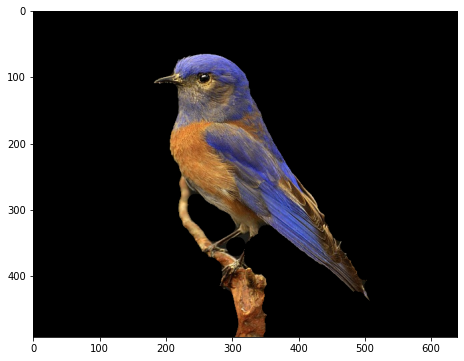

In [24]:
Ic = cv2.imread("images/bird.jpg")
Ic = cv2.cvtColor(Ic, cv2.COLOR_BGR2RGB)

I_new = imask(Ic, I_mask2)
plt.imshow(I_new)
plt.show()

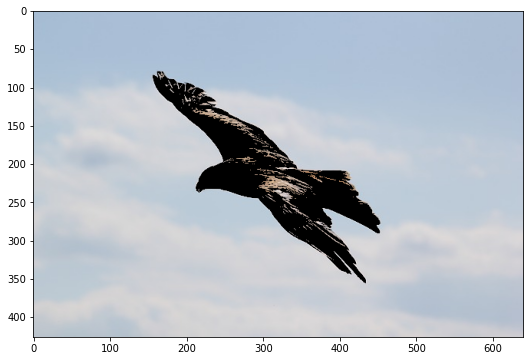

In [25]:
Ic = cv2.imread("images/eagle.jpg")
Ic = cv2.cvtColor(Ic, cv2.COLOR_BGR2RGB)
I = cv2.cvtColor(Ic, cv2.COLOR_BGR2GRAY)

thr = 126 # from Otsu
I_mask = np.zeros_like(I)
I_mask[I<thr] = 0
I_mask[I>=thr] = 1

I_new = imask(Ic, I_mask)
plt.imshow(I_new)
plt.show()

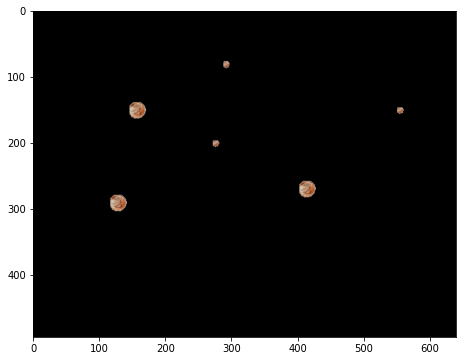

In [76]:
I = cv2.imread("images/coins.jpg")
Ic = cv2.cvtColor(I, cv2.COLOR_BGR2RGB)
I = cv2.cvtColor(I, cv2.COLOR_BGR2GRAY)

thr = 193
I_mask = np.zeros_like(I)
I_mask[I<thr] = 0
I_mask[I>=thr] = 1
I_mask = 1 - I_mask

n = 30
I_mask2 = cv2.morphologyEx(I_mask, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(n,n)))

r = cv2.connectedComponentsWithStats(I_mask2)

areas = r[2][:, -1]
larger = np.where(areas > 700)
replace = np.isin(r[1], larger)
Ic[replace] = 0
plt.imshow(Ic)
plt.show()